In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from datetime import timedelta, date, datetime
from sqlalchemy.types import NVARCHAR, DATE, FLOAT, VARCHAR, DATETIME
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve,\
    plot_confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from helpers import *

data_dir = "../data"

sns.set_style('whitegrid')



## Feature extraction

In [4]:
from sqlalchemy import create_engine
import pandas as pd
import config
from sql_queries import *

engine = create_engine(
    f"mysql+pymysql://{config.sql_credentials['user']}:{config.sql_credentials['password']}@{config.sql_credentials['host']}:{config.sql_credentials['port']}/{config.sql_credentials['db']}",
    pool_pre_ping=True)

conn = engine.connect()
#
# print(datetime.now())
# login_data = pd.read_sql(login_query, conn)
# print(datetime.now())
# dist_data = pd.read_sql(dist_query, conn)
# print(datetime.now())
# prefs_data = pd.read_sql(prefs_query, conn)
# print(datetime.now())
# training_data = pd.read_sql(training_query, conn)
# print(datetime.now())
# worked_data = pd.read_sql(worked_query, conn)
# print(datetime.now())
# days_worked_data = pd.read_sql(days_worked_query,conn)
# print(datetime.now())
# apps_done_data = pd.read_sql(apps_done_query,conn)
# print(datetime.now())
# logs_done_data = pd.read_sql(logs_done_query,conn)
# print(datetime.now())
# print(datetime.now())
# texts_received_data = pd.read_sql(texts_received_query, conn)
# print(datetime.now())
# login_events_data = pd.read_sql(logins_events_query, conn)
# print(datetime.now())
# views_done_data = pd.read_sql(views_done_query, conn)
# print(datetime.now())
# pvs_data = pd.read_sql(pvs_query, conn)
# print(datetime.now())
# md_data = pd.read_sql(md_query, conn)
# print(datetime.now())
#
# md_data.to_csv('../data/md_data.csv', index = False)#
# pvs_data.to_csv('../data/pvs_data.csv', index = False)
# views_done_data.to_csv('../data/views_done_data.csv', index = False)
# login_events_data.to_csv('../data/login_events_data.csv', index = False)
# days_worked_data.to_csv('../data/days_worked_data.csv', index = False)
# logs_done_data.to_csv('../data/logs_done_data.csv', index = False)
# apps_done_data.to_csv('../data/apps_done_data.csv', index = False)
# login_data.to_csv('../data/login_data.csv', index = False)
# dist_data.to_csv('../data/dist_data.csv', index = False)
# worked_data.to_csv('../data/worked_data.csv', index = False)
# prefs_data.to_csv('../data/prefs_data_v2.csv', index = False)
# training_data.to_csv('../data/training_data_v2.csv', index = False)
# texts_received_data.to_csv('../data/texts_received_data.csv', index = False)


## Feature engineering

In [80]:
login_data = pd.read_csv('../data/login_data.csv')
dist_data = pd.read_csv('../data/dist_data.csv')
worked_data = pd.read_csv('../data/worked_data.csv')
prefs_data = pd.read_csv('../data/prefs_data_v2.csv')
training_data = pd.read_csv('../data/training_data_v2.csv')
days_worked_data = pd.read_csv('../data/days_worked_data.csv')
apps_done_data = pd.read_csv('../data/apps_done_data.csv')
logs_done_data = pd.read_csv('../data/logs_done_data.csv')
texts_received_data = pd.read_csv('../data/texts_received_data.csv')
# logins_events_data = pd.read_csv('../data/login_events_data.csv')
views_done_data = pd.read_csv('../data/views_done_data.csv')
pvs_data = pd.read_csv('../data/pvs_data.csv')
md_data = pd.read_csv('../data/md_data.csv')

In [81]:
days_worked_data['date'] = days_worked_data.date.apply(lambda x:str(x))
logs_done_data['date'] = logs_done_data.date.apply(lambda x:str(x))
texts_received_data['date'] = texts_received_data.date.apply(lambda x:str(x))
apps_done_data['date'] = apps_done_data.date.apply(lambda x:str(x))
views_done_data['date'] = views_done_data.date.apply(lambda x:str(x))
pvs_data['sent_at'] = pvs_data['sent_at'].apply(lambda x:str(x))
md_data['sent_at'] = md_data['sent_at'].apply(lambda x:str(x))

training_data['date_sent_at'] = pd.to_datetime(training_data['sent_at'],format='%Y-%m-%d').dt.date.apply(lambda x:str(x))

print(training_data.shape)
all_data = training_data.merge(login_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(prefs_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(dist_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(worked_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(days_worked_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(apps_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data.drop(['date_x','date_y'],axis=1, inplace = True)
print(all_data.shape)
all_data = all_data.merge(logs_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(texts_received_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(views_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(pvs_data, how='left', left_on = ['sent_at','carer_id'],
                          right_on = ['sent_at','carer_id'])
print(all_data.shape)
all_data = all_data.merge(md_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)

all_data.drop_duplicates(subset=['placement_ad_id','carer_id','sent_at'], inplace = True)
print(all_data.shape)


target = 'carer_applied_in_8hrs'

(2246563, 38)
(2246563, 39)
(2246563, 69)
(2246563, 70)
(2246563, 73)
(2246563, 75)
(2246563, 77)
(2246563, 75)
(2246563, 77)
(2246563, 79)
(2246563, 81)
(2246563, 82)
(2246563, 83)
(1963934, 83)


In [82]:
print(f'There are {all_data[target].sum()} applications for {all_data.placement_ad_id.nunique()} placement ads')

There are 17072 applications for 15000 placement ads


In [7]:
all_data.groupby('sms_type')[target].sum()/all_data.groupby('sms_type')[target].count()* 100

sms_type
customListSent            0.647119
initialPromotionSent      2.011581
preferredPlacementSent    1.707971
returningCarerSent        0.810026
slowMatchingSent          1.163568
urgentMatchSent           0.780866
Name: carer_applied_in_8hrs, dtype: float64

### clustering on apps and days worked

In [100]:
df[target].value_counts()

0    16016
1    12125
2     4698
Name: carer_applied_in_8hrs, dtype: int64

In [83]:
all_data['apps_past_7_days'].replace(np.nan,0,inplace = True)
all_data['days_worked_past_90'].replace(np.nan,0,inplace = True)


1
2
3
4
5
6
7
8
9


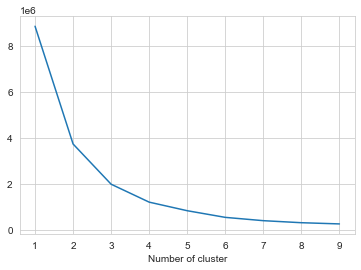

In [10]:
sse={}
df_test = all_data[['apps_past_7_days']]
for k in range(1, 10):
    print(k)
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_test)
    df_test["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
sse={}
df_test = all_data[['days_worked_past_90']]
for k in range(1, 10):
    print(k)
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_test)
    df_test["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [122]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(all_data[['apps_past_7_days']])
all_data['cluster_apps_past_7_days'] = kmeans.predict(all_data[['apps_past_7_days']])


#order the cluster numbers
all_data = order_cluster('cluster_apps_past_7_days', 'apps_past_7_days',all_data,True)

#apply clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(all_data[['days_worked_past_90']])
all_data['cluster_days_worked_past_90'] = kmeans.predict(all_data[['days_worked_past_90']])


#order the cluster numbers
all_data = order_cluster('cluster_days_worked_past_90', 'days_worked_past_90',all_data,True)

### Data preparation

In [123]:
target = 'carer_applied_in_8hrs'

X1 = all_data.loc[all_data['carer_applied_in_8hrs']==1]
X0 = all_data.loc[all_data['carer_applied_in_8hrs']==0].sample(frac=0.01, random_state=1992)

df = pd.concat([X1,X0], axis = 0)
df

,placement_ad_id,match_request_id,carer_id,sent_at,updated_at,sms_type,carer_applied_in_8hrs,lead_time,ongoing,min_provider_rate,...,date_x,login_past_7_days,date_y,texts_past_30_days,date,viewed_placements_past_7_days,predicted_value,difficulty_normalised,cluster_apps_past_7_days,cluster_days_worked_past_90
68,plad_pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8...,pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8c3c-a...,p100146905,2021-07-02 16:17:30,2021-07-02 16:08:38,initialPromotionSent,1,5,0,600.0,...,NaN,NaN,2021-07-02,100.0,NaN,NaN,139.8040,1.705170,0,0
305,plad_pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a...,pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a59b-a...,p100481747,2020-08-17 11:45:35,2020-08-17 11:28:30,initialPromotionSent,1,7,1,650.0,...,2020-08-17,17.0,2020-08-17,23.0,NaN,NaN,84.1962,1.270840,0,0
349,plad_pl_s0VzaXbRWt2i_FUNp-4e81795e-64e0-4fb3-a...,pl_s0VzaXbRWt2i_FUNp-4e81795e-64e0-4fb3-a6f3-5...,p100533752,2019-11-27 18:14:51,2019-11-27 18:13:50,initialPromotionSent,1,17,1,750.0,...,2019-11-27,5.0,2019-11-27,9.0,NaN,NaN,NaN,1.528210,0,0
806,plad_pl_s0FTNImybUXp_StSl-cd36ad4a-2ad1-4a5f-a...,pl_s0FTNImybUXp_StSl-cd36ad4a-2ad1-4a5f-a9be-4...,p10168743,2020-01-31 16:59:22,2020-01-31 16:56:27,initialPromotionSent,1,8,1,725.0,...,2020-01-31,20.0,2020-01-31,3.0,NaN,NaN,132.7760,1.882290,0,0
807,plad_pl_s0Qx87kq7r4F_PV67-8b12f7b1-f1ff-4bf5-9...,pl_s0Qx87kq7r4F_PV67-8b12f7b1-f1ff-4bf5-97e3-4...,p10168743,2020-01-29 17:29:43,2020-01-29 17:26:53,initialPromotionSent,1,12,1,650.0,...,2020-01-29,4.0,NaN,NaN,NaN,NaN,148.1110,1.831800,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108456,plad_pl_s0liOZEmQcyO_Gybz-554afbed-0b2e-479f-8...,pl_s0liOZEmQcyO_Gybz-554afbed-0b2e-479f-87a6-2...,p32980714,2021-06-01 10:17:00,2021-06-01 09:46:52,customListSent,0,2,0,740.0,...,NaN,NaN,2021-06-01,200.0,NaN,NaN,89.3449,1.730620,0,0
1531454,plad_pl_s0oho5ykOdoy_oEc3-7c08cb3b-4db0-4a8f-b...,pl_s0oho5ykOdoy_oEc3-7c08cb3b-4db0-4a8f-bcaa-8...,p134085059,2020-01-19 09:40:59,2020-01-19 09:37:39,urgentMatchSent,0,0,0,550.0,...,2020-01-19,43.0,2020-01-19,14.0,NaN,NaN,187.3750,0.525095,1,0
870771,plad_pl_s0DfZQCVPh9s_CoAG-f13f63f0-2cb9-46cd-8...,pl_s0DfZQCVPh9s_CoAG-f13f63f0-2cb9-46cd-8dd5-1...,p14943223,2020-08-06 11:34:54,2020-08-06 10:33:29,customListSent,0,1,1,550.0,...,2020-08-06,2.0,2020-08-06,83.0,NaN,NaN,97.3474,1.753370,0,0
999314,plad_pl_s0HxNXgfuDgY_xWV5-0c94c700-5df1-4a09-a...,pl_s0HxNXgfuDgY_xWV5-0c94c700-5df1-4a09-aadc-7...,p124340188,2019-11-23 11:28:33,2019-11-22 18:19:45,customListSent,0,2,1,550.0,...,NaN,NaN,2019-11-23,32.0,NaN,NaN,NaN,1.548100,0,0


In [106]:
df[target].unique()

array([1, 0])

In [124]:
predictors = df.columns.tolist()

[predictors.remove(x) for x in [target,
'match_request_id',
'carer_id',
'sent_at',
'updated_at',
'set_at',
'latitude',
'longitude',
'start_date_time',
'date',
'date_x',
'date_y',
'date_sent_at',
'carer_logged_in_7_days',
'texts_past_30_days',
'carer_worked_in_30_days',
'predicted_value'] if x in predictors]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [125]:
df = df.loc[df.lead_time>0]
df['texts_past_30_days'].replace(np.nan,0,inplace = True)
df['login_past_7_days'].replace(np.nan,0,inplace = True)
# df['apps_past_7_days'].replace(np.nan,0,inplace = True)
# df['days_worked_past_90'].replace(np.nan,0,inplace = True)
df['carer_worked_in_7_days'].replace(np.nan,0,inplace = True)
df['carer_worked_in_30_days'].replace(np.nan,0,inplace = True)
df['carer_logged_in_7_days'].replace(np.nan,0,inplace = True)
df['viewed_placements_past_7_days'].replace(np.nan,0,inplace = True)


df = pd.get_dummies(df,columns=['sms_type'],drop_first=True)

df['max_cr_age']= df['max_cr_age'].clip(18,118)

df['log_lead_time'] = np.log(np.where(df['lead_time']>0,df['lead_time'],0.01))
df['exp_lead_time'] = np.exp(np.where(df['lead_time']>0,df['lead_time'],0.01))
df['log_lead_time'] = df.log_lead_time.clip(0)

#carer likes X and X is there
df['met_licence'] = df['has_licence'] * df['licence_needed']
df['met_car'] = df['has_car'] * df['car_needed']

df['met_moving_handling'] = df['moving_handling'] * df['carer_moving_handling']
df['met_stoma'] = df['stoma'] * df['carer_stoma']
df['met_dementia'] = df['dementia'] * df['carer_dementia']
df['met_alzheimers'] = df['alzheimers'] * df['carer_alzheimers']
df['met_parkinsons'] = df['parkinsons'] * df['carer_parkinsons']
df['met_stroke'] = df['stroke'] * df['carer_stroke']
df['met_diabetes'] = df['diabetes'] * df['carer_diabetes']
df['met_peg'] = df['peg'] * df['carer_peg']
df['met_hoist'] = df['hoist'] * df['carer_hoist']
df['met_mental_health_issue'] = df['mental_health_issues'] * df['carer_mental_health_issues']

df['met_distance_50'] = np.where((df['maxDistance_50']==1) & (df['distance_km']*1.61 <= 50),1,0 )
df['met_distance_100'] = np.where((df['maxDistance_100']==1) & (df['distance_km']*1.61 <= 100),1,0 )
df['met_distance_400'] = np.where((df['maxDistance_400']==1) & (df['distance_km']*1.61 <= 400),1,0 )

#carer doesn't like X and X is not there
df['met_smoking'] = np.where((df['smoking'] == 0 )& (df['smokingClientsExclusion'] ==1),1,0)
df['met_dogs'] = np.where((df['has_dogs'] == 0) & (df['petsExclusion_DOGS'] ==1),1,0)
df['met_cats'] = np.where((df['has_cats'] == 0 )& (df['petsExclusion_CATS'] ==1),1,0)
df['met_2crs'] = np.where((df['has_two_crs'] == 0) & (df['recipientNumberExclusion_2CRs'] ==1),1,0)
df['met_cr_gender'] = np.where((df['recipient_1_male'] == 0) & (df['genderExclusion_MALE'] ==1),1,0)


df['met_ear_WHITE_ALL'] = np.where((df['ethnicities_at_risk_WHITE_ALL'] ==0) & (df['ethnicityExclusion_WHITE_ALL'] ==1),1,0)
df['met_ear_MIXED_ALL'] = np.where((df['ethnicities_at_risk_MIXED_ALL'] ==0) & (df['ethnicityExclusion_MIXED_ALL'] ==1),1,0)
df['met_ear_BLACK_ALL'] = np.where((df['ethnicities_at_risk_BLACK_ALL'] ==0) & (df['ethnicityExclusion_BLACK_ALL'] ==1),1,0)
df['met_ear_ASIAN_ALL'] = np.where((df['ethnicities_at_risk_ASIAN_ALL'] ==0) & (df['ethnicityExclusion_ASIAN_ALL'] ==1),1,0)
df['met_ear_ARAB_ALL'] = np.where((df['ethnicities_at_risk_ARAB_ALL'] ==0) & (df['ethnicityExclusion_ARAB_ALL'] ==1),1,0)

#carer doesn't like X but X is there
df['broken_ear_WHITE_ALL'] = df['ethnicities_at_risk_WHITE_ALL'] * df['ethnicityExclusion_WHITE_ALL']
df['broken_ear_MIXED_ALL'] = df['ethnicities_at_risk_MIXED_ALL']* df['ethnicityExclusion_MIXED_ALL']
df['broken_ear_BLACK_ALL'] = df['ethnicities_at_risk_BLACK_ALL'] * df['ethnicityExclusion_BLACK_ALL']
df['broken_ear_ASIAN_ALL'] = df['ethnicities_at_risk_ASIAN_ALL'] * df['ethnicityExclusion_ASIAN_ALL']
df['broken_ear_ARAB_ALL'] = df['ethnicityExclusion_ARAB_ALL'] * df['ethnicityExclusion_ARAB_ALL']


## count of soft preferences that are met
df['count_soft_preferences'] = df['met_distance_50'] +  df['met_distance_100'] + df['met_distance_400'] + \
                               df['met_smoking'] + df['met_dogs'] + df['met_cats'] + df['met_2crs'] + \
                               df['met_cr_gender'] + df['met_ear_WHITE_ALL']  + df['met_ear_MIXED_ALL']  + \
                               df['met_ear_BLACK_ALL']  + df['met_ear_ASIAN_ALL'] +df['met_ear_ARAB_ALL']

In [588]:
## interactions of "every" feature with the top three

adj_predictors = predictors
[adj_predictors.remove(x) for x in ['placement_ad_id','apps_past_7_days',
                                    'days_worked_past_90','distance_km','sms_type'] if x in adj_predictors]

for p in adj_predictors:
    # print(p)
    df[f'days_worked_{p}'] = df['days_worked_past_90'] * df[p]
    df[f'apps_past_{p}'] = df['apps_past_7_days'] * df[p]
    df[f'distance_{p}'] = df['distance_km'] * df[p]


In [114]:
df[target].value_counts()

0    18169
1    16325
Name: carer_applied_in_8hrs, dtype: int64

In [111]:
df['days_worked_past_90'].value_counts()

0.0     19251
14.0      794
7.0       754
28.0      458
21.0      399
        ...  
85.0       28
87.0       21
86.0       21
88.0       16
89.0       15
Name: days_worked_past_90, Length: 91, dtype: int64

In [126]:
df['grouped_days_worked_past_90'] = np.where(df['days_worked_past_90'] == 0,0,np.nan)
df.loc[(df['days_worked_past_90']>0) & (df['days_worked_past_90']<=45) ,'grouped_days_worked_past_90'] = 1
df.loc[(df['days_worked_past_90']>45),'grouped_days_worked_past_90'] = 2
df['grouped_days_worked_past_90'].value_counts()

0.0    19333
1.0    10500
2.0     4675
Name: grouped_days_worked_past_90, dtype: int64

In [127]:
df['grouped_apps_past_7_days'] = np.where(df['apps_past_7_days'] == 0,0,np.nan)
df.loc[(df['apps_past_7_days']>0) & (df['apps_past_7_days']<8) ,'grouped_apps_past_7_days'] = 1
df.loc[(df['apps_past_7_days']>7),'grouped_apps_past_7_days'] = 2
df['grouped_apps_past_7_days'].value_counts()

0.0    20342
1.0    10030
2.0     4136
Name: grouped_apps_past_7_days, dtype: int64

## Feature selection

In [128]:
predictors = df.columns.tolist()

[predictors.remove(x) for x in [target,
'match_request_id',
'carer_id',
'sent_at',
'updated_at',
'set_at',
'latitude',
'longitude',
'start_date_time',
'date',
'date_x',
'date_y',
'date_sent_at',
'carer_logged_in_7_days',
'texts_past_30_days',
'carer_worked_in_30_days',
'predicted_value'] if x in predictors]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [129]:
for p in predictors:
    if df[p].isna().sum()>0:
        print(p,df[p].isna().sum())

print(df.shape)
df = df.loc[df[predictors].notnull().all(axis=1)]
print(df.shape)

max_cr_age 359
ethnicityExclusion_ARAB_ALL 258
ethnicityExclusion_ASIAN_ALL 258
ethnicityExclusion_BLACK_ALL 258
ethnicityExclusion_MIXED_ALL 258
ethnicityExclusion_WHITE_ALL 258
genderExclusion_MALE 258
maxDistance_50 258
maxDistance_100 258
maxDistance_400 258
petsExclusion_CATS 258
petsExclusion_DOGS 258
recipientNumberExclusion_2CRs 258
smokingClientsExclusion 258
has_licence 258
has_car 258
carer_moving_handling 258
carer_dementia 258
carer_mental_health_issues 258
carer_hoist 258
carer_parkinsons 258
carer_stroke 258
carer_alzheimers 258
carer_stoma 258
carer_diabetes 258
carer_peg 258
carer_age 305
log_career_years_of_experience 938
log_years_on_elder 535
carer_gender_FEMALE 258
distance_km 157
difficulty_normalised 89
met_licence 258
met_car 258
met_moving_handling 258
met_stoma 258
met_dementia 258
met_alzheimers 258
met_parkinsons 258
met_stroke 258
met_diabetes 258
met_peg 258
met_hoist 258
met_mental_health_issue 258
broken_ear_WHITE_ALL 258
broken_ear_MIXED_ALL 258
broken_

In [308]:
# X_train, X_eval, y_train, y_eval = split_train_test(df.sort_values('placement_ad_id'),predictors,target,shuffle = False, test_size=0.25)
#
# print(f'There are {X_train.placement_ad_id.nunique()} placements in the training set with {y_train.sum().values[0]} applications')
# print(f'There are {X_eval.placement_ad_id.nunique()} placements in the eval set with {y_eval.sum().values[0]} applications')
#
# X_train.drop('placement_ad_id', axis = 1, inplace= True)
# X_eval.drop('placement_ad_id', axis = 1, inplace= True)

There are 9602 placements in the training set with 11930 applications
There are 3290 placements in the eval set with 4137 applications


In [130]:
X_train, X_eval, y_train, y_eval = split_train_test(df,predictors,target,test_size=0.25)

print(f'There are {X_train.placement_ad_id.nunique()} placements in the training set with {y_train.sum().values[0]} applications')
print(f'There are {X_eval.placement_ad_id.nunique()} placements in the eval set with {y_eval.sum().values[0]} applications')

X_train.drop('placement_ad_id', axis = 1, inplace= True)
X_eval.drop('placement_ad_id', axis = 1, inplace= True)

There are 8689 placements in the training set with 11559 applications
There are 5080 placements in the eval set with 3815 applications


In [131]:
scaler = StandardScaler()
model = LogisticRegression(max_iter=10000)

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_eval = pd.DataFrame(scaler.transform(X_eval), index=X_eval.index, columns=X_eval.columns)


In [ ]:
n_features =6
X = X_train
y = np.ravel(y_train)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

recall_scorer = make_scorer(recall_score, greater_is_better=True)
precision_scorer = make_scorer(precision_score, greater_is_better=True) #gets zero positive examples in some folds

results = select_features(rf, n_features, y, X,scoring=recall_scorer)

Running for 1 features


In [25]:
f_predictors = list(set(sum(list(results.loc[results.cv_score == results.cv_score.max()]['features']), [])))

NameError: name 'results' is not defined

In [ ]:
heat_list = f_predictors + [target]

fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.lineplot(x=range(1, n_features), y=results['cv_score'], ax = ax[0], linewidth = 3)
sns.heatmap(training_data[heat_list].corr(), cmap='Blues', annot=True, ax = ax[1])

## Model performance

### Baseline

In [95]:
df[target].unique()

array([1, 2, 0])

In [132]:
 # 'days_worked_past_90',
f_predictors = [
'difficulty_normalised','grouped_days_worked_past_90','grouped_apps_past_7_days',
    'carer_gender_FEMALE','log_lead_time','distance_km',
    'has_dogs','log_years_on_elder', 'max_cr_age',
     'min_provider_rate','ethnicities_at_risk_BLACK_ALL', 'ongoing'
]
model.fit(X_train[f_predictors], np.ravel(y_train))


preds = model.predict(X_eval[f_predictors])
pred_probs = model.predict_proba(X_eval[f_predictors])

print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')
#Recall is 0.79298, accuracy is 0.82878, precision is 0.83292 grouped
#Recall is 0.7327, accuracy is 0.80905, precision is 0.83863 continuous
#Recall is 0.68021, accuracy is 0.78553, precision is 0.82987 cluster

Recall is 0.68021, accuracy is 0.78553, precision is 0.82987


In [ ]:
pred_probs = model.predict_proba(X_eval)

print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

pred_proba_df = pd.DataFrame(pred_probs)
for i in np.arange(0.0, 1.0, 0.05):
    print (f'\n for i = {i} ')
    y_test_pred = pred_proba_df[1].apply(lambda x: 1 if x>i else 0)

    print(f'Eval accuracy is {accuracy_score(y_eval,y_test_pred)}')
    print(f'Eval precision is {precision_score(y_eval,y_test_pred)}')
    print(f'Eval recall is {recall_score(y_eval,y_test_pred)}')

    if (i==0.05) | (round(i,2)==0.95):
        print(confusion_matrix(y_eval,y_test_pred))


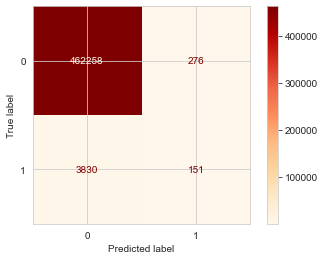

In [523]:
plot_confusion_matrix(model,X_eval[f_predictors],y_eval, cmap = 'OrRd')

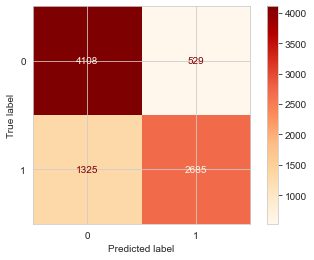

In [595]:
plot_confusion_matrix(model,X_eval[f_predictors],y_eval, cmap = 'OrRd')

#### Random forest

In [27]:

rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))


preds = rf.predict(X_eval)

In [46]:
for x in forest_importances:
    print(x,np.std(x, axis = 0))

AxisError: axis 0 is out of bounds for array of dimension 0

In [53]:
print(len(rf.estimators_) , len(forest_importances),X_train.shape[1])

100 104 104


In [ ]:
importances = rf.feature_importances_
importances[::-1].sort()
forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree for tree in forest_importances], axis=0)

fig, ax = plt.subplots(figsize=(15,10))
forest_importances.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [494]:
ff_predictors = set([
 'apps_past_7_days',
 'apps_past_carer_worked_in_7_days',
 'apps_past_difficulty_normalised',
 'apps_past_ethnicities_at_risk_ARAB_ALL',
 'apps_past_ethnicities_at_risk_BLACK_ALL',
 'apps_past_has_licence',
 'apps_past_has_two_crs',
 'apps_past_has_wifi',
 'apps_past_lead_time',
 'apps_past_log_career_years_of_experience',
 'apps_past_log_years_on_elder',
 'apps_past_maxDistance_100',
 'apps_past_max_cr_age',
 'apps_past_min_provider_rate',
 'apps_past_mental_health_issues',
 'apps_past_ongoing',
 'apps_past_peg',
 'apps_past_recipient_1_male',
 'carer_gender_FEMALE',
 'carer_worked_in_7_days',
 'days_worked_carer_moving_handling',
 'days_worked_carer_worked_in_7_days',
 'days_worked_max_cr_age',
 'days_worked_past_90',
 'days_worked_peg',
 'difficulty_normalised',
 'distance_carer_moving_handling',
 'distance_difficulty_normalised',
 'distance_ethnicities_at_risk_ASIAN_ALL',
 'distance_km',
 'distance_log_career_years_of_experience',
 'distance_login_past_7_days',
 'distance_max_cr_age',
 'ethnicities_at_risk_ARAB_ALL',
 'ethnicities_at_risk_ASIAN_ALL',
 'has_dogs',
 'has_licence',
 'hoist',
 'log_lead_time',
 'log_years_on_elder',
 'login_past_7_days',
 'min_provider_rate',
    'log_lead_time'
])



model.fit(X_train[ff_predictors], np.ravel(y_train))

preds = model.predict(X_eval[ff_predictors])
print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

Recall is 0.76118, accuracy is 0.81984, precision is 0.83734


In [496]:
test = {'feature':[],'value':[]}
for f,v in zip(ff_predictors,model.coef_[0]):
    test['feature'].append(f)
    test['value'].append(np.abs(v))

test = pd.DataFrame(test)

test.sort_values('value', ascending = False)

,feature,value
20,apps_past_max_cr_age,1.032980
34,login_past_7_days,1.024714
13,apps_past_7_days,1.002743
32,apps_past_min_provider_rate,0.864982
4,apps_past_carer_worked_in_7_days,0.833089
8,days_worked_past_90,0.610818
26,carer_worked_in_7_days,0.502961
27,carer_gender_FEMALE,0.456497
22,days_worked_carer_moving_handling,0.425867
17,distance_carer_moving_handling,0.425403


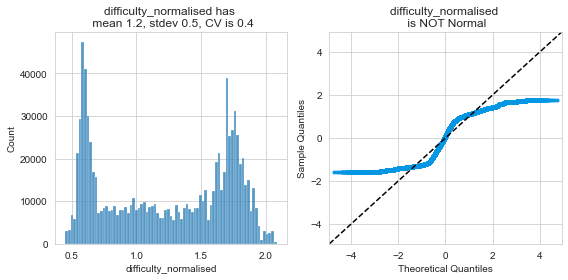

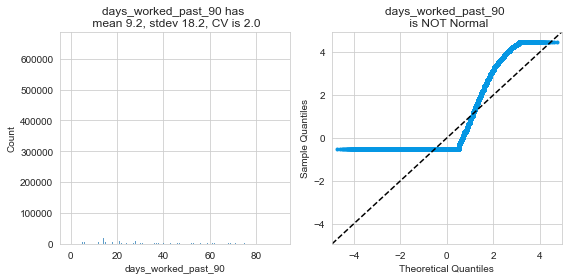

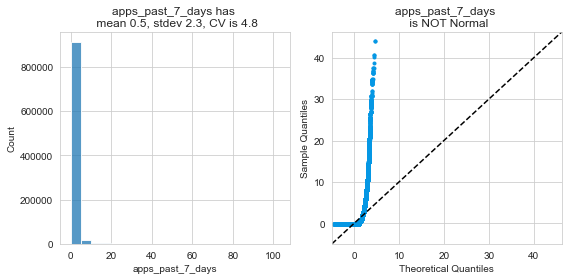

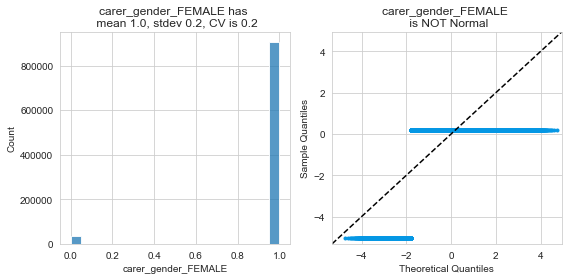

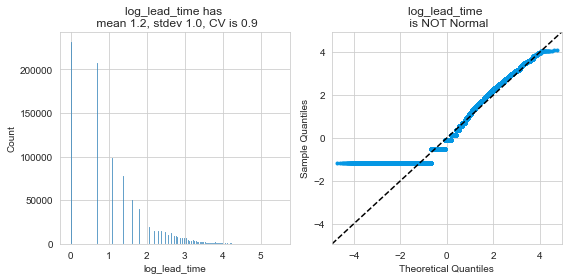

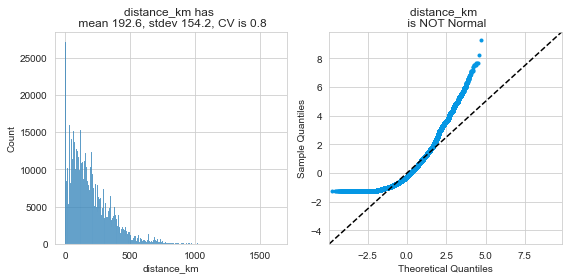

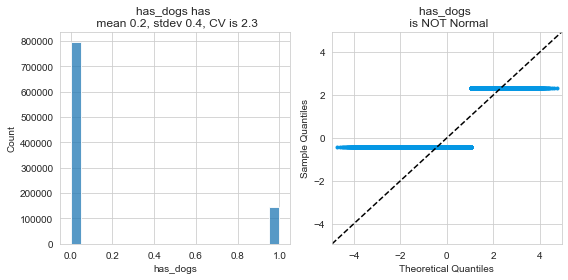

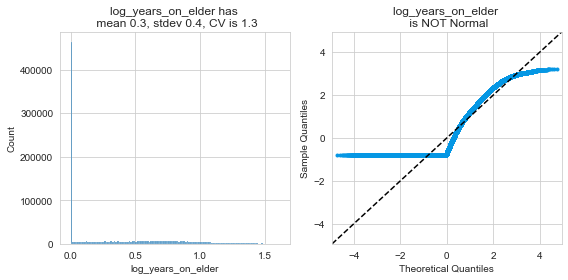

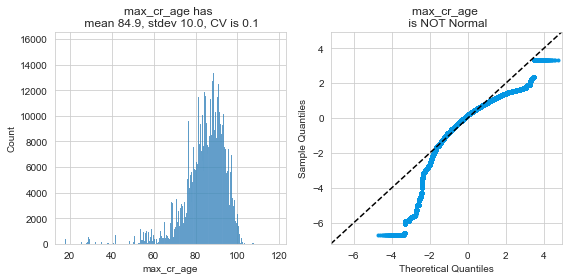

In [478]:
for f in f_predictors:
    plot_histogram(f, df)

<AxesSubplot:>

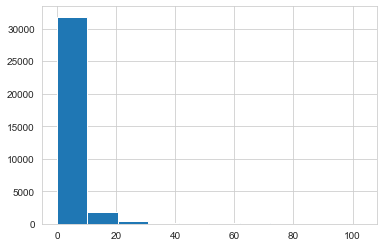

In [397]:
df['apps_past_7_days'].hist()

In [583]:
df.groupby('carer_gender_FEMALE')['carer_id'].count()

carer_gender_FEMALE
0.0      8636
1.0    192468
Name: carer_id, dtype: int64

In [320]:
df.groupby('carer_gender_FEMALE')['carer_id'].nunique()

carer_gender_FEMALE
0.0     607
1.0    3814
Name: carer_id, dtype: int64

We care more about recall than precision for two reasons:

 - conversion apps/messages is less important than apps/placements
 - reaching relevant carers could increase apps/placements and carer 'engagement'

On a balanced sample (around 50% each applied/not applied), the model
['predicted_value','days_worked_past_90','apps_past_7_days','carer_gender_FEMALE'] does a fair job at classifying positive examples
correctly, showing an accuracy of 77.7% together with i) a recall score of 62.7%
and ii) a precision of 81% on the evaluation set (not used for FS)



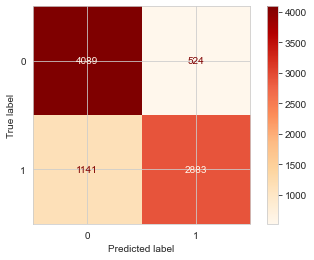

In [509]:
plot_confusion_matrix(model,X_eval[f_predictors],y_eval, cmap = 'OrRd')


  0%|          | 0/1000 [00:00<?, ?it/s]

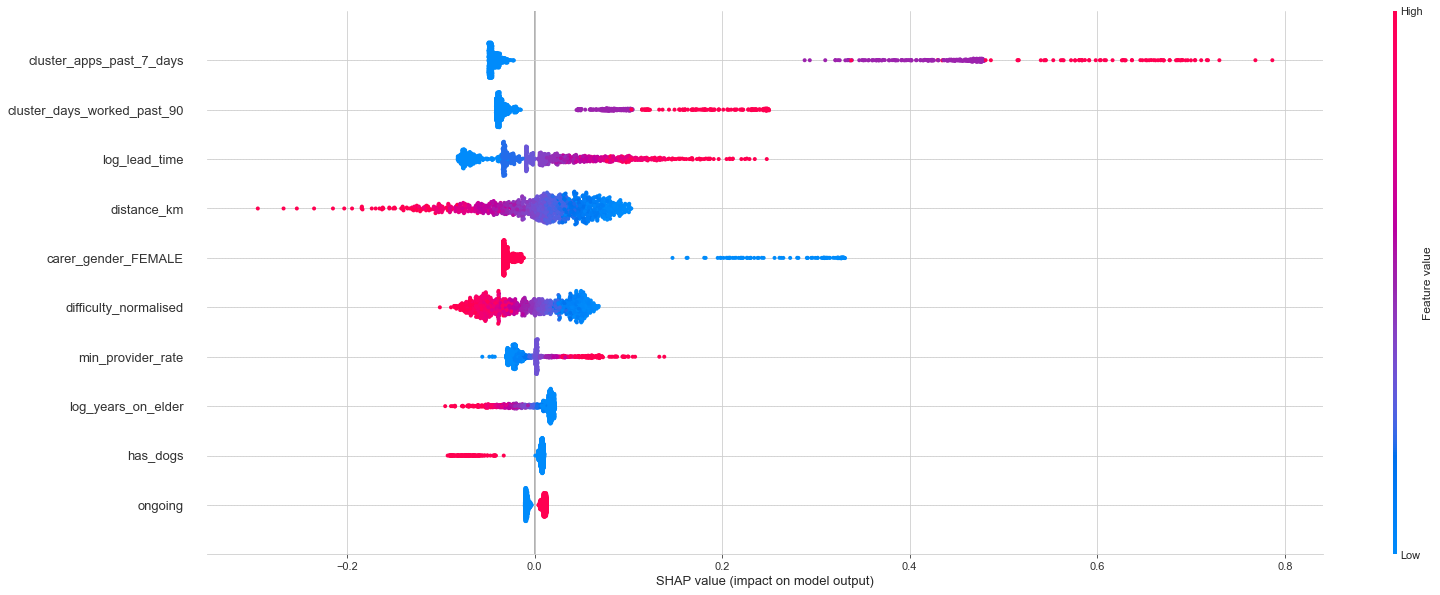

In [597]:
import warnings
warnings.filterwarnings('ignore')


scaler = StandardScaler()
scaler.fit(X_train[f_predictors])

masker = shap.maskers.Impute(data=scaler.transform(X_train[f_predictors]), )

model = LogisticRegression()
model.fit(X_eval[f_predictors],np.ravel(y_eval))

def model_predict_proba(x):
    return model.predict_proba(x)[:,1] #only returning probability of class 1

explainer = shap.KernelExplainer(model_predict_proba, X_train[f_predictors][:50], masker=masker)
shap_values = explainer.shap_values(X_eval[f_predictors][:1000])
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
plt.subplot(1, 1, 1)
shap.summary_plot(shap_values, X_eval[f_predictors][:1000], max_display=10, show=False, plot_size=None )


In [ ]:
plot_shap_metrics(model,df,f_predictors,target)

## Testing gradient boosting

In [655]:
model.fit(X_train, np.ravel(y_train))

preds = model.predict(X_eval)
print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')



Recall is 0.74843, accuracy is 0.82169, precision is 0.85177


In [610]:
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree


In [656]:
xgb = XGBClassifier()

xgb.fit(X_train, np.ravel(y_train))

preds = xgb.predict(X_eval)
print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

[13:57:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Recall is 0.83753, accuracy is 0.84971, precision is 0.84017


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

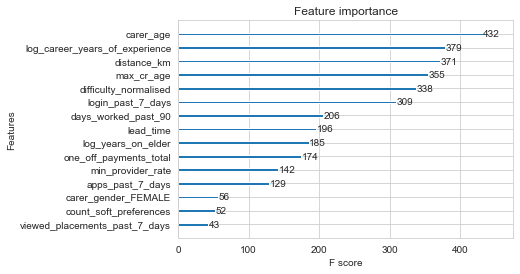

In [657]:
plot_importance(xgb, max_num_features=15)


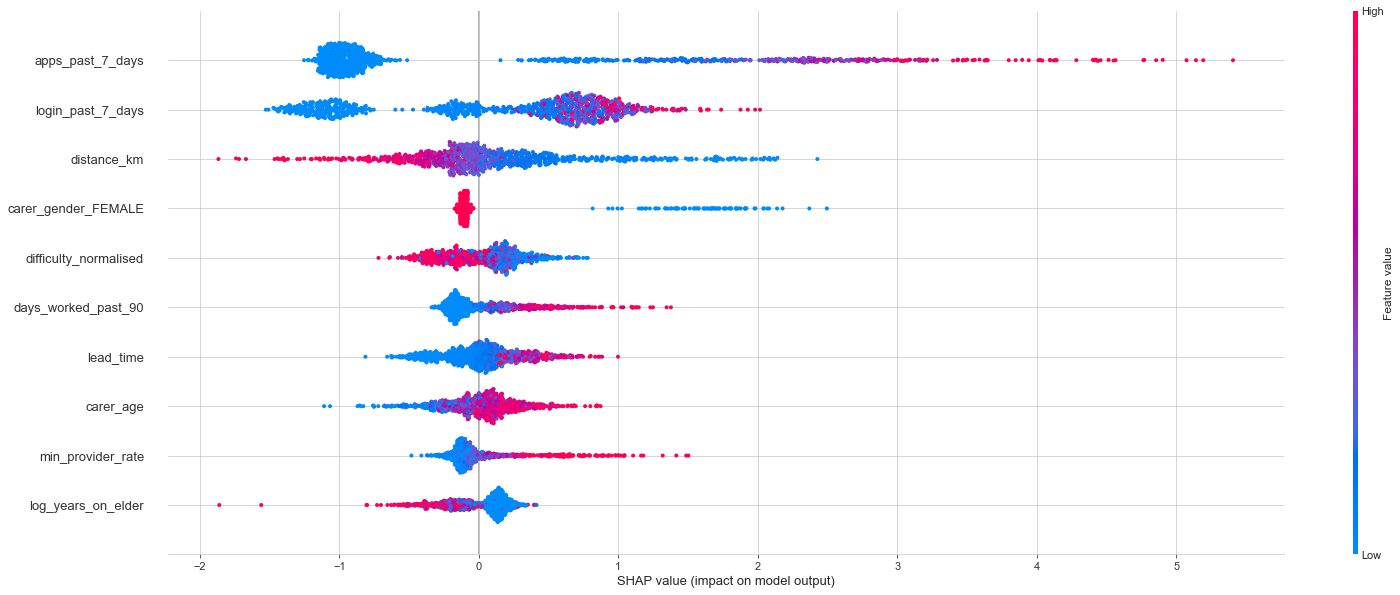

In [658]:
masker = shap.maskers.Impute(data=scaler.transform(X_train), )

tree_explainer = shap.TreeExplainer(xgb,X_train[:100], masker=masker)
shap_values = tree_explainer.shap_values(X_eval[:1000])
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
plt.subplot(1, 1, 1)
shap.summary_plot(shap_values, X_eval[:1000], max_display=10, show=False, plot_size=None )

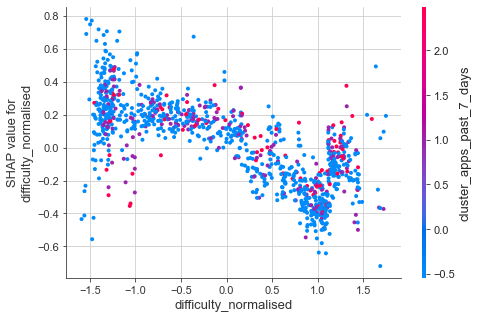

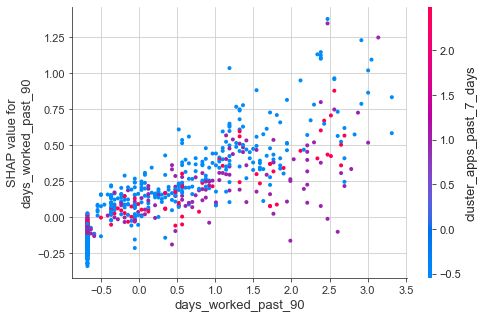

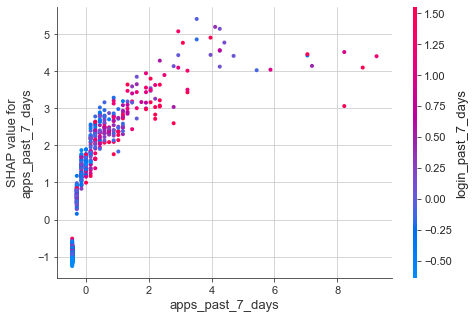

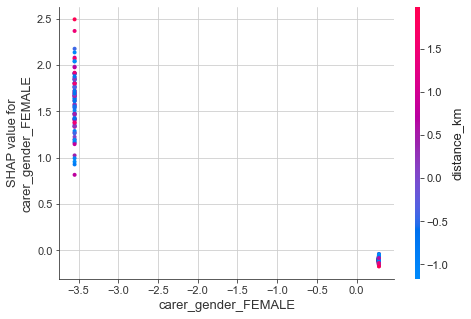

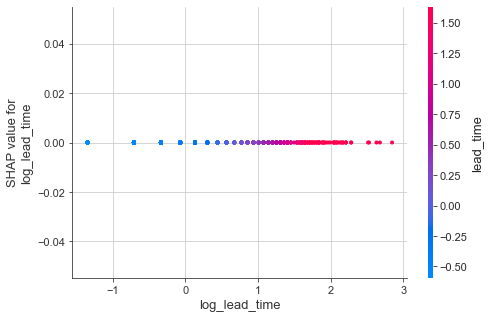

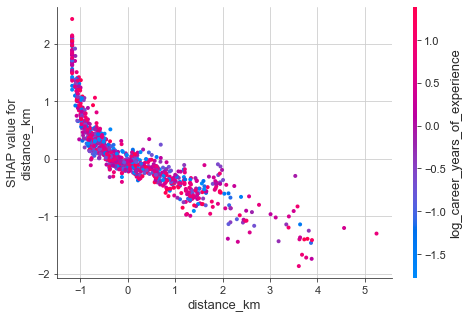

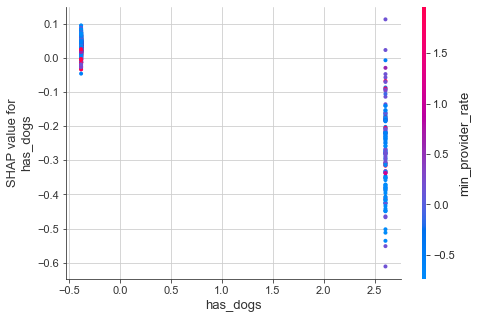

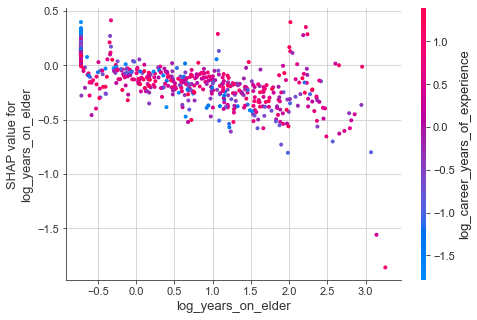

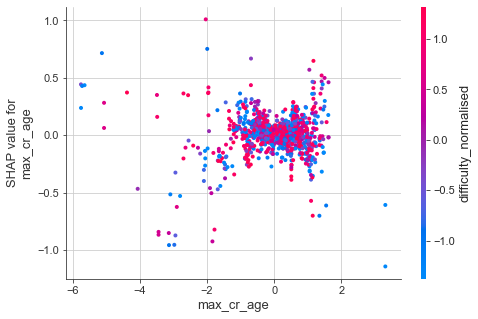

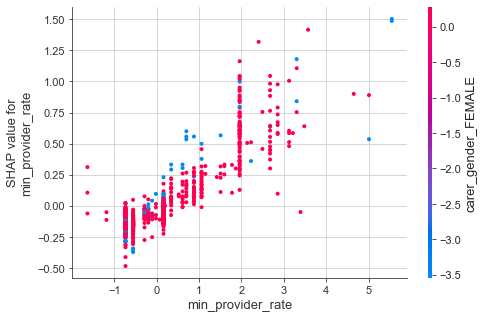

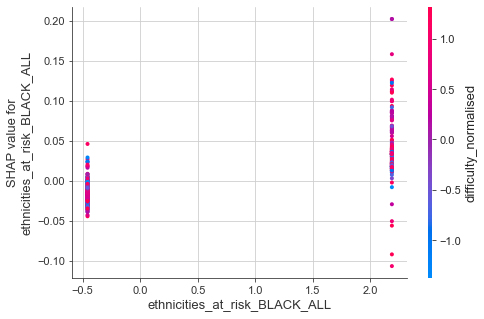

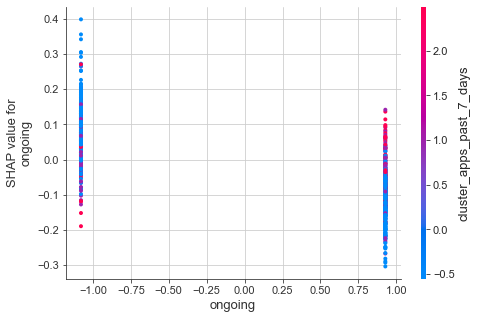

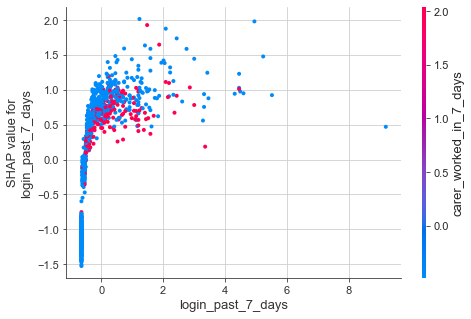

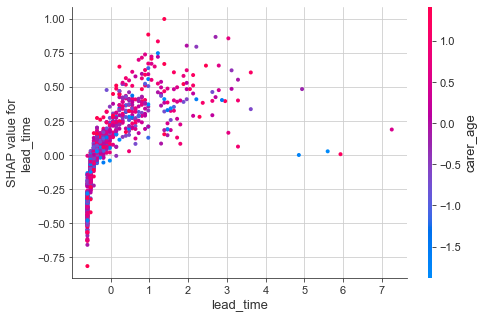

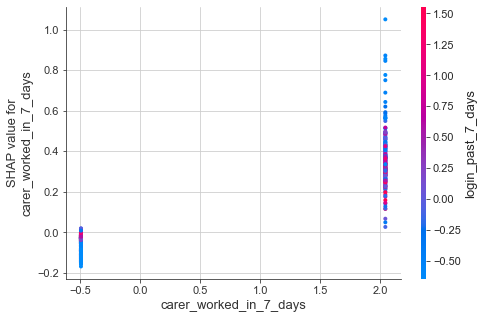

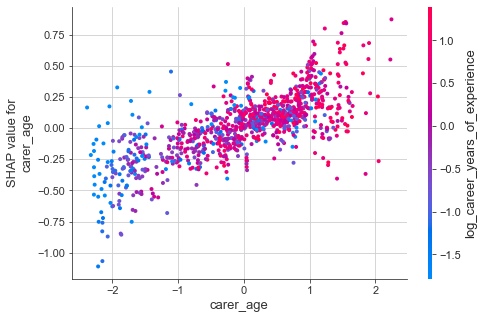

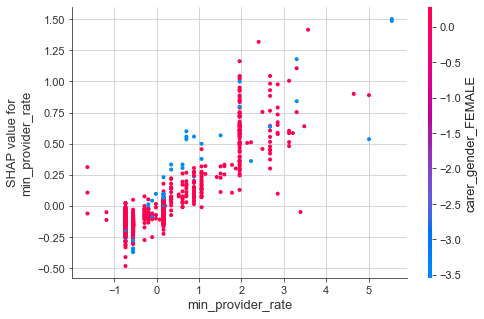

In [659]:
for f in [
'difficulty_normalised','days_worked_past_90','apps_past_7_days',
    'carer_gender_FEMALE','log_lead_time','distance_km',
    'has_dogs','log_years_on_elder', 'max_cr_age',
     'min_provider_rate','ethnicities_at_risk_BLACK_ALL', 'ongoing',
    'login_past_7_days','lead_time','carer_worked_in_7_days','carer_age','min_provider_rate'
]:
    shap.dependence_plot(f, shap_values, X_eval[:1000])


In [ ]:
shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X_eval[:1000])
shap.summary_plot(shap_interaction_values, X_eval[:1000], max_display=20)

In [665]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf = LogisticRegression()
selector = SequentialFeatureSelector(n_features_to_select=5, n_jobs=-1, direction='forward',
                                             estimator=rf
                                             )
selector.fit(X_train, y_train)
support = selector.get_support()
features = list(X.columns[support])

Exception in thread Thread-29:
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.6/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 973, in _bootstrap_inner
  File "/Users/bonaventurapacileo/Documents/mo/carer_targeting/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 558, in run
    self.terminate_broken(bpe)
  File "/Users/bonaventurapacileo/Documents/mo/carer_targeting/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 736, in terminate_broken
    self.kill_workers()
  File "/Users/bonaventurapacileo/Documents/mo/carer_targeting/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 766, in kill_workers
    recursive_terminate(p)
  File "/Users/bonaventurapacileo/Documents/mo/carer_targeting/venv/lib/python3.9/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9), SIGKILL(-9)}

# ADD months from activation, pre live, new working carer, hour, pop score,